In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

In [2]:
trash = pd.read_csv('../data/trash_hauler_report.csv')

In [3]:
trash

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y
0,25270,11/01/17,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1.727970e+06,686779.478089
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1.721259e+06,685444.799565
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1.707027e+06,659887.471571
3,25307,11/01/17,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1.735692e+06,685027.245923
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1.710186e+06,664205.101066
...,...,...,...,...,...,...,...,...,...,...,...
20221,267125,11/01/19,Trash - Curbside/Alley Missed Pickup,MISSED...NEIGHBORS MISSED,2731 Murfreesboro Pike,37013.0,RED RIVER,4502,32.0,1.781137e+06,632448.551144
20222,267126,11/01/19,Trash - Curbside/Alley Missed Pickup,entire alley,"1621 Long Ave, Nashville, TN 37206, United States",37206.0,METRO,9508,6.0,1.749711e+06,669201.601569
20223,267130,11/01/19,Trash - Curbside/Alley Missed Pickup,missed several,"2943 Windemere Cir, Nashville, TN 37214, Unite...",37214.0,RED RIVER,1502,15.0,1.770293e+06,674936.303809
20224,267134,11/01/19,Trash - Curbside/Alley Missed Pickup,Caller stated trash was missed & were only pic...,"3325 Murfreesboro Pike, Nashville, TN 37013, U...",37013.0,RED RIVER,4502,32.0,1.785225e+06,627146.400187


In [4]:
trash['Zip Code'] = trash['Zip Code'].astype(str)
trash['Council District'] = trash['Council District'].astype(str)
trash['Zip Code'] = trash['Zip Code'].str[:5]
trash['Council District'] = trash['Council District'].str[:-2]
trash['Incident Address'] = trash['Incident Address'].str.title()
trash.columns = trash.columns.str.rstrip()
trash['Incident Address'] = trash['Incident Address'].str.split(',', expand = True)[0]
trash['Description'] = trash['Description'].str.title()
trash['Miss_In_Description'] = trash['Description'].str.extract('(Miss)')
trash['Trash Hauler'] = trash['Trash Hauler'].str.title()
trash

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,Miss_In_Description
0,25270,11/01/17,Trash - Backdoor,"House With The Wheel Chair Ramp, They Share Dr...",3817 Crouch Dr,37207,Red River,3205,2,1.727970e+06,686779.478089,NaN
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,4028 Clarksville Pike,37218,Red River,4202,1,1.721259e+06,685444.799565,Miss
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,6528 Thunderbird Dr,37209,Red River,4205,20,1.707027e+06,659887.471571,Miss
3,25307,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed,2603 Old Matthews Rd,37207,Waste Ind,2206,2,1.735692e+06,685027.245923,Miss
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed The Even Side Of The Road.,604 Croley Dr,37209,Red River,4203,20,1.710186e+06,664205.101066,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
20221,267125,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed...Neighbors Missed,2731 Murfreesboro Pike,37013,Red River,4502,32,1.781137e+06,632448.551144,Miss
20222,267126,11/01/19,Trash - Curbside/Alley Missed Pickup,Entire Alley,1621 Long Ave,37206,Metro,9508,6,1.749711e+06,669201.601569,NaN
20223,267130,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed Several,2943 Windemere Cir,37214,Red River,1502,15,1.770293e+06,674936.303809,Miss
20224,267134,11/01/19,Trash - Curbside/Alley Missed Pickup,Caller Stated Trash Was Missed & Were Only Pic...,3325 Murfreesboro Pike,37013,Red River,4502,32,1.785225e+06,627146.400187,Miss


In [5]:
Red_River = trash.loc[trash['Trash Hauler'] == 'Red River']
Red_River

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,Miss_In_Description
0,25270,11/01/17,Trash - Backdoor,"House With The Wheel Chair Ramp, They Share Dr...",3817 Crouch Dr,37207,Red River,3205,2,1.727970e+06,686779.478089,NaN
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,4028 Clarksville Pike,37218,Red River,4202,1,1.721259e+06,685444.799565,Miss
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,6528 Thunderbird Dr,37209,Red River,4205,20,1.707027e+06,659887.471571,Miss
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed The Even Side Of The Road.,604 Croley Dr,37209,Red River,4203,20,1.710186e+06,664205.101066,Miss
5,25317,11/01/17,Trash Collection Complaint,Left Trash Cart In Middle Of Driveway Instead ...,3602 Floral Dr,37211,Red River,4304,16,1.751660e+06,643215.201073,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20220,267121,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed,2709 Crestdale Dr,37214,Red River,1502,15,1.770240e+06,676334.399319,Miss
20221,267125,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed...Neighbors Missed,2731 Murfreesboro Pike,37013,Red River,4502,32,1.781137e+06,632448.551144,Miss
20223,267130,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed Several,2943 Windemere Cir,37214,Red River,1502,15,1.770293e+06,674936.303809,Miss
20224,267134,11/01/19,Trash - Curbside/Alley Missed Pickup,Caller Stated Trash Was Missed & Were Only Pic...,3325 Murfreesboro Pike,37013,Red River,4502,32,1.785225e+06,627146.400187,Miss


In [6]:
Red_River_Miss = Red_River.loc[(Red_River.Request == 'Trash - Curbside/Alley Missed Pickup') | (Red_River.Miss_In_Description == 'Miss')]
Red_River_Miss

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,Miss_In_Description
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,4028 Clarksville Pike,37218,Red River,4202,1,1.721259e+06,685444.799565,Miss
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,6528 Thunderbird Dr,37209,Red River,4205,20,1.707027e+06,659887.471571,Miss
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed The Even Side Of The Road.,604 Croley Dr,37209,Red River,4203,20,1.710186e+06,664205.101066,Miss
8,25330,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed.,4484 Lavergne Couchville Pike,37013,Red River,4210,33,1.794534e+06,618749.342732,Miss
10,25341,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed Trash Pickup - Resident Has At Curb For...,3113 Hydes Ferry Rd,37218,Red River,4204,2,1.721578e+06,676018.399900,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
20220,267121,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed,2709 Crestdale Dr,37214,Red River,1502,15,1.770240e+06,676334.399319,Miss
20221,267125,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed...Neighbors Missed,2731 Murfreesboro Pike,37013,Red River,4502,32,1.781137e+06,632448.551144,Miss
20223,267130,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed Several,2943 Windemere Cir,37214,Red River,1502,15,1.770293e+06,674936.303809,Miss
20224,267134,11/01/19,Trash - Curbside/Alley Missed Pickup,Caller Stated Trash Was Missed & Were Only Pic...,3325 Murfreesboro Pike,37013,Red River,4502,32,1.785225e+06,627146.400187,Miss


In [7]:
Red_River_Miss['Incident Address'].value_counts()

Incident Address
12546 Old Hickory Blvd      21
5135 Hickory Hollow Pkwy    20
6007 Obrien Ave             19
3710 N Natchez Ct           19
1584 Bell Rd                18
                            ..
212 Donna Dr                 1
6302 Robertson Ave           1
713 23Rd St                  1
211 Donna Dr                 1
604 Somerset Ct              1
Name: count, Length: 8240, dtype: int64

In [8]:
Red_River_Fines = ((Red_River_Miss['Incident Address'].value_counts()-1)*200).to_frame().reset_index()
Red_River_Fines

,Incident Address,count
0,12546 Old Hickory Blvd,4000
1,5135 Hickory Hollow Pkwy,3800
2,6007 Obrien Ave,3600
3,3710 N Natchez Ct,3600
4,1584 Bell Rd,3400
...,...,...
8235,212 Donna Dr,0
8236,6302 Robertson Ave,0
8237,713 23Rd St,0
8238,211 Donna Dr,0


In [9]:
Red_River_Fines.sum()

Incident Address    12546 Old Hickory Blvd5135 Hickory Hollow Pkwy...
count                                                          919400
dtype: object

* What other types of complaints are there?

In [11]:
trash['Description']

0        House With The Wheel Chair Ramp, They Share Dr...
1                                 Curb/Trash Miss Tuesday.
2                                 Curb/Trash Miss Tuesday.
3                                                   Missed
4                        Missed The Even Side Of The Road.
                               ...                        
20221                            Missed...Neighbors Missed
20222                                         Entire Alley
20223                                       Missed Several
20224    Caller Stated Trash Was Missed & Were Only Pic...
20225                       Possibly Others Missed As Well
Name: Description, Length: 20226, dtype: object

* Make a heat map that shows the most total missed pick ups and another that shows the total fines, each by zip code.

In [13]:
trash_miss = trash.loc[(trash.Request == 'Trash - Curbside/Alley Missed Pickup') | (Red_River.Miss_In_Description == 'Miss')]
trash_miss

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,Miss_In_Description
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,4028 Clarksville Pike,37218,Red River,4202,1,1.721259e+06,685444.799565,Miss
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash Miss Tuesday.,6528 Thunderbird Dr,37209,Red River,4205,20,1.707027e+06,659887.471571,Miss
3,25307,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed,2603 Old Matthews Rd,37207,Waste Ind,2206,2,1.735692e+06,685027.245923,Miss
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed The Even Side Of The Road.,604 Croley Dr,37209,Red River,4203,20,1.710186e+06,664205.101066,Miss
8,25330,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed.,4484 Lavergne Couchville Pike,37013,Red River,4210,33,1.794534e+06,618749.342732,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
20221,267125,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed...Neighbors Missed,2731 Murfreesboro Pike,37013,Red River,4502,32,1.781137e+06,632448.551144,Miss
20222,267126,11/01/19,Trash - Curbside/Alley Missed Pickup,Entire Alley,1621 Long Ave,37206,Metro,9508,6,1.749711e+06,669201.601569,NaN
20223,267130,11/01/19,Trash - Curbside/Alley Missed Pickup,Missed Several,2943 Windemere Cir,37214,Red River,1502,15,1.770293e+06,674936.303809,Miss
20224,267134,11/01/19,Trash - Curbside/Alley Missed Pickup,Caller Stated Trash Was Missed & Were Only Pic...,3325 Murfreesboro Pike,37013,Red River,4502,32,1.785225e+06,627146.400187,Miss


In [14]:
trash_miss_by_zip = trash_miss.groupby('Zip Code')['Trash Hauler'].value_counts().unstack().fillna(0)
trash_miss_by_zip

Trash Hauler,Metro,Red River,Waste Ind
Zip Code,,,
37013,1.0,2024.0,0.0
37027,0.0,136.0,0.0
37086,0.0,3.0,0.0
37115,1.0,1019.0,0.0
37189,0.0,54.0,0.0
37201,16.0,0.0,5.0
37203,241.0,0.0,54.0
37204,198.0,329.0,0.0
37205,90.0,1111.0,0.0


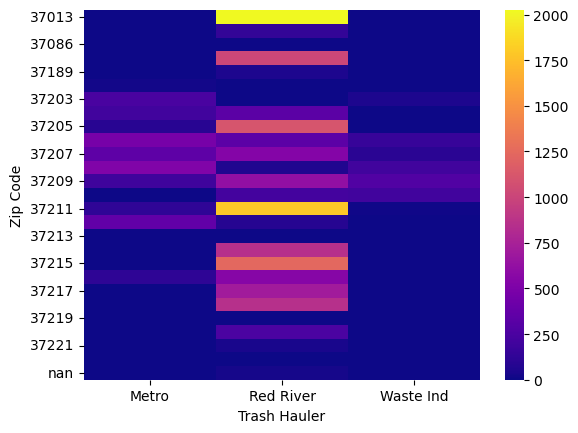

In [15]:
sns.heatmap(trash_miss_by_zip, cmap = 'plasma');

In [16]:
trash_miss = trash_miss.loc[(trash_miss.Miss_In_Description == 'Miss')]
trash_miss['Incident Address'].nunique()

8305

In [17]:
trash_miss['Number Missed'] = 1


C:\Users\maitl\AppData\Local\Temp\ipykernel_13036\3733498180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_miss['Number Missed'] = 1


In [18]:
trash_miss = trash_miss[['Incident Address', 'Zip Code', 'Trash Hauler', 'Number Missed']]

In [38]:
trash_miss = trash_miss.groupby(['Incident Address', 'Zip Code', 'Trash Hauler']).count()
trash_miss['Number Missed'].value_sort()

AttributeError: 'Series' object has no attribute 'value_sort'